In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121,DenseNet169, ResNet101,ResNet101V2,ResNet152V2, InceptionResNetV2, InceptionV3 ,VGG16, VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

In [2]:
# Import system libraries
import os
import time
import shutil
import pathlib
import itertools
import warnings
warnings.filterwarnings("ignore")

# Import data handling tools
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from glob import glob
from skimage.util import montage as montage2d
from skimage.io import imread

# Import machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, 
    BatchNormalization, MaxPool2D, GlobalAveragePooling2D, 
    Input, Concatenate
)
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Inline plotting
%matplotlib inline

print('Modules loaded')

Modules loaded


In [3]:
df = pd.read_csv("/kaggle/input/tb-classification-project-dataset/12 DATA PENYAKIT DAN NO FINDING PART 1.csv")
# Assuming the dataset contains 'Image Index' and 'Finding Labels'
columns_to_keep = ['Image Index', 'Finding Labels']

# Filter the dataset to retain only the required columns
df = df[columns_to_keep]
globs = glob('../input/tb-classification-project-dataset/12 DATA PENYAKIT DAN NO FINDING PART 1/12 DATA PENYAKIT DAN NO FINDING PART 1/images_*/images/*.png')
full_img_paths = {os.path.basename(x): x for x in globs}
df['Image Path'] = df['Image Index'].map(full_img_paths.get)
df.sample(3)

,Image Index,Finding Labels,Image Path
17536,00002779_000.png,No Finding,../input/tb-classification-project-dataset/12 ...
21193,00000184_001.png,No Finding,../input/tb-classification-project-dataset/12 ...
24310,00000744_001.png,Nodule,../input/tb-classification-project-dataset/12 ...


In [4]:
df = df[df['Finding Labels'] != 'Consolidation']
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: 'Normal' if x == 'No Finding' else 'Non-TB')

Number of unique labels: 2 

                count
Finding Labels       
Non-TB          19151
Normal           8750 



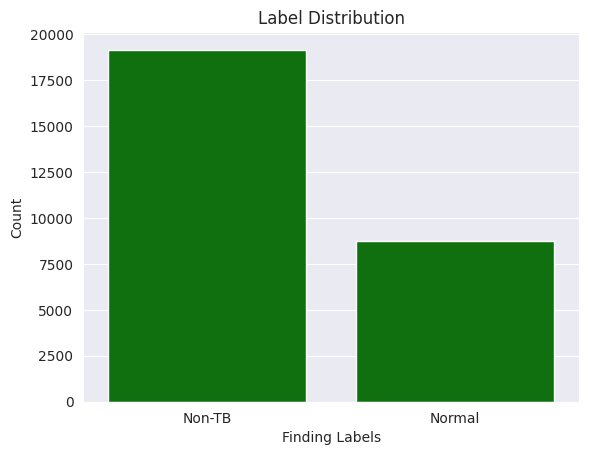

In [5]:
# Explore the dataset a bit

# Q: how many unique labels are there? A: many (836) because of co-occurence
# Note: co-occurence will turn out to be a real pain to deal with later, but there are several techniques that help us work with it successfully
num_unique_labels = df['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels, '\n')

# let's look at the label distribution to better plan our next step
count_per_unique_label = df['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes
print(df_count_per_unique_label, '\n') # print the frequency counts

# Visualize the label distribution using a bar plot
sns.barplot(x=df_count_per_unique_label.index, y='count', data=df_count_per_unique_label,color = "green")
plt.title('Label Distribution')
plt.xlabel('Finding Labels')
plt.ylabel('Count')
plt.show()


Label: Non-TB


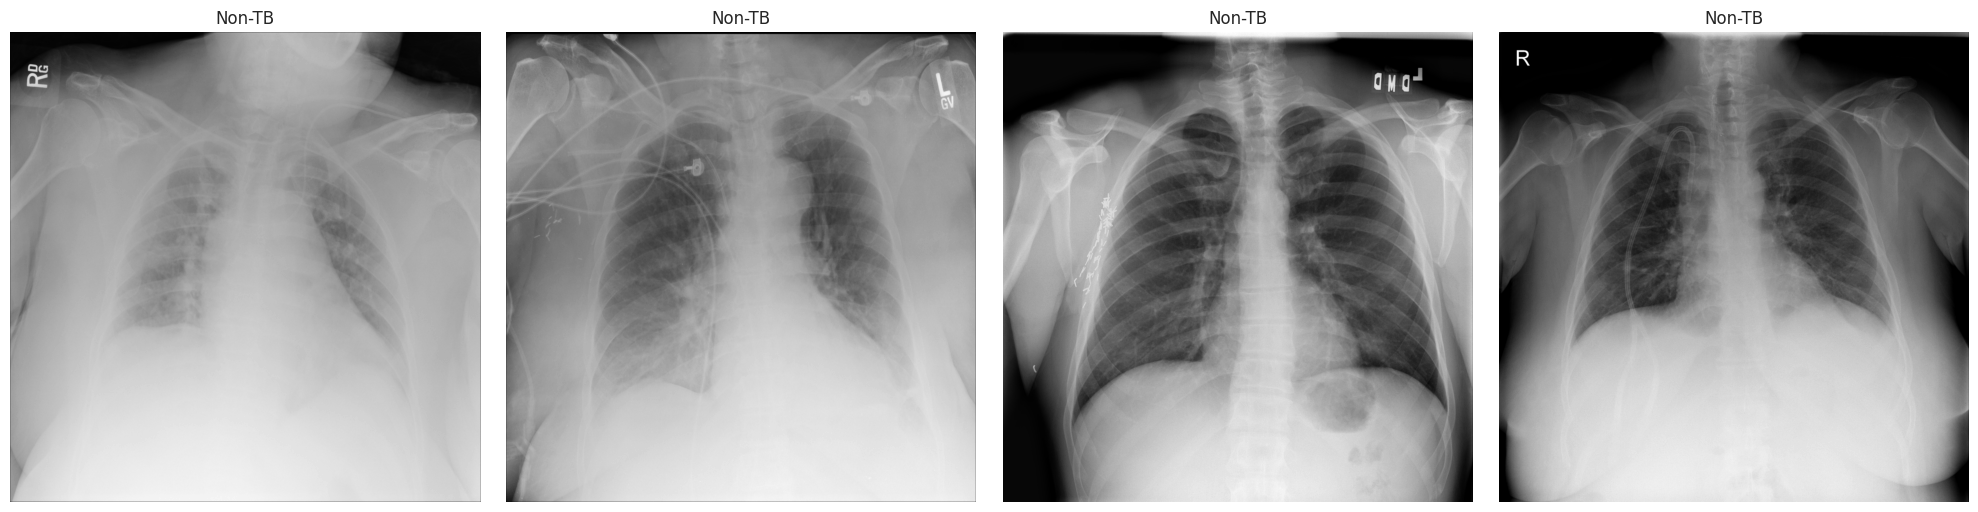


Label: Normal


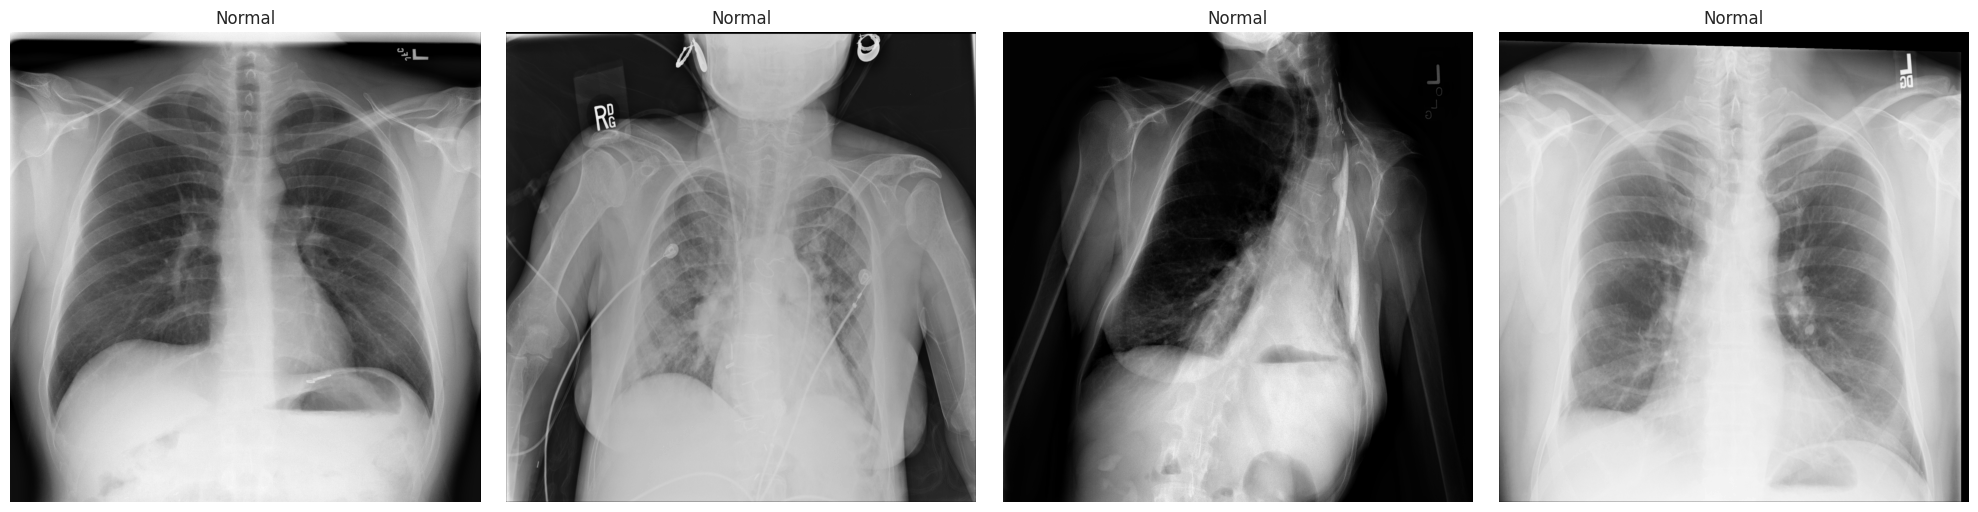

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_images_horizontally(df, num_images_per_label=4):
  for label in df['Finding Labels'].unique():
    print(f"\nLabel: {label}")
    label_df = df[df['Finding Labels'] == label]

    # Select random images for the label
    image_paths = label_df['Image Path'].sample(n=num_images_per_label, random_state=42) 

    # Create a figure and subplots
    fig, axes = plt.subplots(1, num_images_per_label, figsize=(20, 5)) 

    for i, path in enumerate(image_paths):
      img = mpimg.imread(path) 
      # Ensure image data is in float32 for proper scaling
      img = img.astype('float32') 
      # Normalize image data to range [0, 1]
      img_normalized = (img - img.min()) / (img.max() - img.min()) 
      axes[i].imshow(img_normalized, cmap='gray') 
      axes[i].set_title(label)
      axes[i].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Assuming your DataFrame is named 'df'
print_images_horizontally(df)

## Load additional Datasets

In [7]:
root_dir = '../input/additional-tb-datasets'
data_gen = ImageDataGenerator()

additional_data = []
labels = []

for label_dir in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label_dir)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            additional_data.append(image_path)
            labels.append(label_dir)

# Combine the primary dataset with the additional data
additional_df = pd.DataFrame({
    'Image Path': additional_data,
    'Finding Labels': labels
})
additional_df

,Image Path,Finding Labels
0,../input/additional-tb-datasets/TB/tb0329.png,TB
1,../input/additional-tb-datasets/TB/tb0139.png,TB
2,../input/additional-tb-datasets/TB/111TBXINA (...,TB
3,../input/additional-tb-datasets/TB/CHNCXR_0572...,TB
4,../input/additional-tb-datasets/TB/CHNCXR_0547...,TB
...,...,...
5427,../input/additional-tb-datasets/Non-TB/COVID(2...,Non-TB
5428,../input/additional-tb-datasets/Non-TB/COVID(4...,Non-TB
5429,../input/additional-tb-datasets/Non-TB/nejmoa2...,Non-TB
5430,../input/additional-tb-datasets/Non-TB/sub-S09...,Non-TB


Number of unique labels: 3 

                count
Finding Labels       
Normal           3800
TB               1430
Non-TB            202 



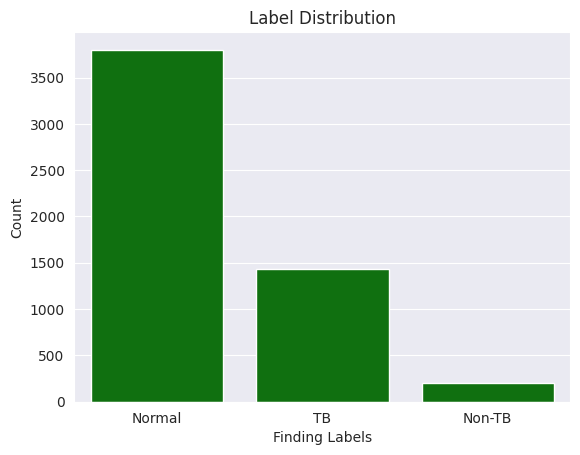

In [8]:
# Explore the dataset a bit

# Q: how many unique labels are there? A: many (836) because of co-occurence
# Note: co-occurence will turn out to be a real pain to deal with later, but there are several techniques that help us work with it successfully
num_unique_labels = additional_df['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels, '\n')

# let's look at the label distribution to better plan our next step
count_per_unique_label = additional_df['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes
print(df_count_per_unique_label, '\n') # print the frequency counts

# Visualize the label distribution using a bar plot
sns.barplot(x=df_count_per_unique_label.index, y='count', data=df_count_per_unique_label,color = "green")
plt.title('Label Distribution')
plt.xlabel('Finding Labels')
plt.ylabel('Count')
plt.show()

## Combine and Encode Datasets

In [9]:
data = pd.concat([df.drop("Image Index",axis=1), additional_df], ignore_index=True)
data

,Finding Labels,Image Path
0,Non-TB,../input/tb-classification-project-dataset/12 ...
1,Non-TB,../input/tb-classification-project-dataset/12 ...
2,Non-TB,../input/tb-classification-project-dataset/12 ...
3,Non-TB,../input/tb-classification-project-dataset/12 ...
4,Non-TB,../input/tb-classification-project-dataset/12 ...
...,...,...
33328,Non-TB,../input/additional-tb-datasets/Non-TB/COVID(2...
33329,Non-TB,../input/additional-tb-datasets/Non-TB/COVID(4...
33330,Non-TB,../input/additional-tb-datasets/Non-TB/nejmoa2...
33331,Non-TB,../input/additional-tb-datasets/Non-TB/sub-S09...


Number of unique labels: 3 

                count
Finding Labels       
Non-TB          19353
Normal          12550
TB               1430 



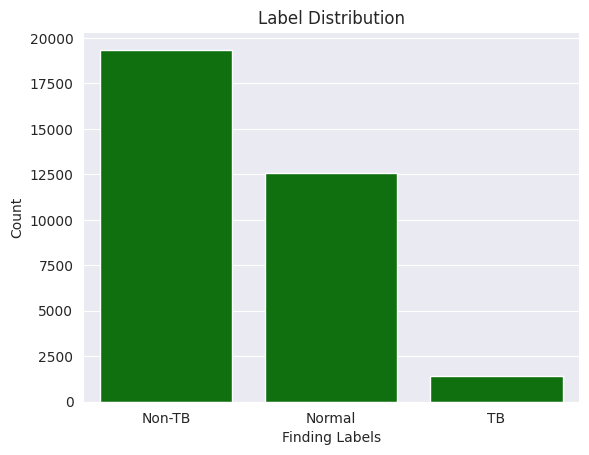

In [10]:
# Explore the dataset a bit

# Q: how many unique labels are there? A: many (836) because of co-occurence
# Note: co-occurence will turn out to be a real pain to deal with later, but there are several techniques that help us work with it successfully
num_unique_labels = data['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels, '\n')

# let's look at the label distribution to better plan our next step
count_per_unique_label = data['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes
print(df_count_per_unique_label, '\n') # print the frequency counts

# Visualize the label distribution using a bar plot
sns.barplot(x=df_count_per_unique_label.index, y='count', data=df_count_per_unique_label,color = "green")
plt.title('Label Distribution')
plt.xlabel('Finding Labels')
plt.ylabel('Count')
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder
# Encode the labels
label_encoder = LabelEncoder()
data['Encoded Labels'] = label_encoder.fit_transform(data['Finding Labels'])

# Print the label encoding for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding:")
for label, encoding in label_mapping.items():
    print(f"{label}: {encoding}")

Label Encoding:
Non-TB: 0
Normal: 1
TB: 2


## Data Splitting and Training

In [12]:
batch_size = 32
img_height = 256
img_width = 256
categories = 3

In [13]:
CATEGORIES = ["Non-TB", "Normal","Tuberculosis"]

In [14]:
# split the data into a training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 1993,stratify=data['Encoded Labels'])

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations): ', len(test_set))
print('prior, full data set - # of observations): ', len(data))

training set - # of observations:  26666
test set - # of observations):  6667
prior, full data set - # of observations):  33333


In [15]:
data_gen = ImageDataGenerator(rescale=1./255)

train_generator = data_gen.flow_from_dataframe(
    train_set,
    x_col='Image Path',
    y_col='Finding Labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_dataframe(
    test_set,
    x_col='Image Path',
    y_col='Finding Labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 26666 validated image filenames belonging to 3 classes.
Found 6667 validated image filenames belonging to 3 classes.


In [16]:
# Check for GPU availability before get into next step
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs are available:")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPUs found.")

GPUs are available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [17]:
num_classes = train_set['Encoded Labels'].nunique()
print(f"There are {num_classes} categories in the dataset.")

There are 3 categories in the dataset.


In [18]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(3, activation="softmax")(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    return model

In [19]:
def load_DenseNet169():
    baseModel = DenseNet169(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3))
    
    model = FCLayers(baseModel)
    return model

# model= load_DenseNet169()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])

In [20]:
def load_DenseNet121():
    baseModel = DenseNet121(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3))
    
    model = FCLayers(baseModel)
    return model

# model= load_DenseNet121()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])

In [21]:
def Inception(X, p1, p2, p3, p4):
    # Path 1 is a  1x1 convolutional layer
    p1_1 = Conv2D(p1, kernel_size=(1,1), activation='relu')(X)
    # Path 2 is a 1x1 convolutional layer followed by a 3x3 convolutional layer
    p2_1 = Conv2D(p2[0], 1, 1, activation='relu')(X)
    p2_2 = Conv2D(p2[1], 3, 1, padding='same', activation='relu')(p2_1)
    # Path 3 is a 1x1 convolutional layer followed by a 5x5 convolutional layer
    p3_1 = Conv2D(p3[0], 1, 1, activation='relu')(X)
    p3_2 = Conv2D(p3[1], 5, 1, padding='same', activation='relu')(p3_1)
    # Path 4 is a 3x3 max pooling layer followed by a 1x1 convolutional layer
    p4_1 = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(X)
    p4_2 = Conv2D(p4, 1, 1, activation='relu')(p4_1)
    # Concatenate the outputs on the channel dimension
    return Concatenate(axis=-1)([p1_1, p2_2, p3_2, p4_2])

def GoogLeNet(shape=(256, 256, 3), classes=3):

    X_input = Input(shape)
    X = Conv2D(64, kernel_size=7, strides=2, padding='same')(X_input)
    X = BatchNormalization()(X) # Regularization technique
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv2D(64, kernel_size=1, strides=1, padding='same')(X)
    X = Conv2D(192, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization()(X) # Regularization technique
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    
    X = Inception(X, 64, (96,128), (16,32), 32)
    X = Inception(X, 128, (128,192), (32,96), 64)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    X = Inception(X, 192, (96, 208), (16, 48), 64)
    X = Inception(X, 160, (112, 224), (24, 64), 64)
    X = Inception(X, 128, (128, 256), (24, 64), 64)
    X = Inception(X, 112, (144, 288), (32, 64), 64)
    X = Inception(X, 256, (160, 320), (32, 128), 128)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    X = Inception(X, 256, (160, 320), (32, 128), 128)
    X = Inception(X, 384, (192, 384), (48, 128), 128)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.4)(X)
    X = Dense(classes, activation='softmax')(X)
    model = Model(inputs=X_input, outputs=X, name="GoogLeNet")
    return model

model= GoogLeNet()
# # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])

In [22]:
def load_ResNet101():
    baseModel = ResNet101(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3),
                            weights="imagenet")
    
    model = FCLayers(baseModel)
    return model

# model= load_ResNet101()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])

In [23]:
def load_InceptionResNetV2():
    baseModel = InceptionResNetV2(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3),
                            weights="imagenet")
    
    model = FCLayers(baseModel)
    return model

# model= load_InceptionResNetV2()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])


In [24]:
def load_InceptionV3():
    baseModel = InceptionV3(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3),
                            weights="imagenet")
    
    model = FCLayers(baseModel)
    return model

# model= load_InceptionV3()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])


In [25]:
def load_ResNet101V2():
    baseModel = ResNet101V2(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3),
                            weights="imagenet")
    
    model = FCLayers(baseModel)
    return model

# model= load_ResNet101V2()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])


In [26]:
def load_ResNet152V2():
    baseModel = ResNet152V2(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3),
                            weights="imagenet")
    
    model = FCLayers(baseModel)
    return model

# model= load_ResNet152V2()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])


In [27]:
def load_VGG16():
    baseModel = VGG16(pooling='avg',
                            include_top=False, 
                            input_shape=(256,256,3))
    
    model = FCLayers(baseModel)
    return model

# model= load_VGG16()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])

In [28]:
# def load_VGG19():
#     baseModel = VGG19(pooling='avg',
#                             include_top=False, 
#                             input_shape=(256,256,3))
    
#     model = FCLayers(baseModel)
#     return model

# model= load_VGG19()
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "AUC"])

In [29]:
import gc
gc.collect()

30867

In [30]:
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def getMetrics(type_):
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics('accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics('val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '.weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics('val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]
callbacks_ = getCallbacks('DenseNet121_FULLDATA')

In [31]:
# Training parameters
epochs = 50  # Adjust the number of epochs as needed

# Train the model
with tf.device('/GPU:0'):  # Change the index if you have multiple GPUs
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        callbacks=callbacks_,
        epochs=epochs,
        steps_per_epoch=train_generator.samples // 80,
        validation_steps=val_generator.samples // 80,
        verbose=1
    )

# Save the trained model for future use
model.save('densenet121_classification_models.h5')

# Evaluate the model performance
train_loss, train_acc, train_auc = model.evaluate(train_generator, verbose=1)
val_loss, val_acc, val_auc = model.evaluate(val_generator, verbose=1)

print(f"Training Loss: {train_loss}, Accuracy: {train_acc}, AUC: {train_auc}")
print(f"Validation Loss: {val_loss}, Accuracy: {val_acc}, AUC: {val_auc}")

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - AUC: 0.7822 - accuracy: 0.5720 - loss: 0.8385
Epoch 1: val_loss improved from inf to 0.81636, saving model to DenseNet121_FULLDATA.weights.h5
333/333 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - AUC: 0.7823 - accuracy: 0.5722 - loss: 0.8383 - val_AUC: 0.8065 - val_accuracy: 0.5791 - val_loss: 0.8164 - learning_rate: 1.0000e-05
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - AUC: 0.8479 - accuracy: 0.6643 - loss: 0.7059
Epoch 2: val_loss did not improve from 0.81636
333/333 ━━━━━━━━━━━━━━━━━━━━ 294s 886ms/step - AUC: 0.8480 - accuracy: 0.6644 - loss: 0.7058 - val_AUC: 0.7879 - val_accuracy: 0.5877 - val_loss: 0.8486 - learning_rate: 1.0800e-04
Epoch 3/50
168/333 ━━━━━━━━━━━━━━━━━━━━ 1:38 596ms/step - AUC: 0.8608 - accuracy: 0.6759 - loss: 0.6709
Epoch 3: val_loss improved from 0.81636 to 0.80911, saving model to DenseNet121_FULLDATA.weights.h5
333/333 ━━━━━━━━━━━━━━━━━━━━ 133s 402ms/step - AUC: 0.8638 - accuracy: 0.6826 - loss: 0.66

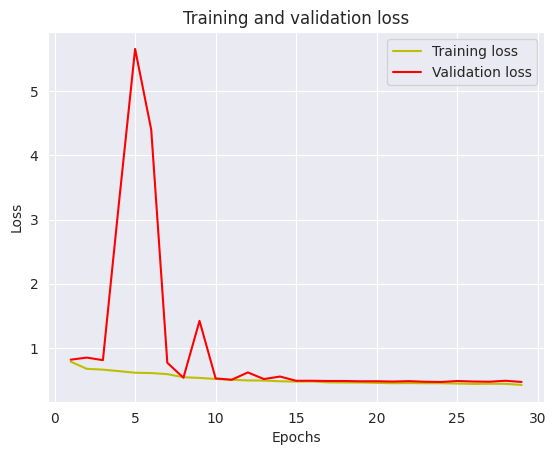

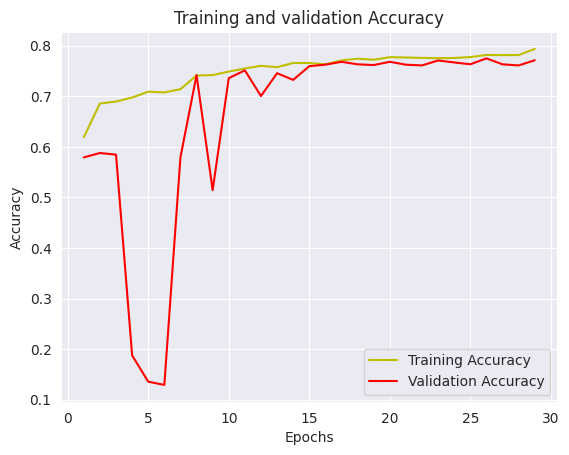

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

209/209 ━━━━━━━━━━━━━━━━━━━━ 104s 486ms/step
Classification Report
              precision    recall  f1-score   support

      Non-TB       0.75      0.90      0.82      3871
      Normal       0.78      0.54      0.64      2510
Tuberculosis       0.96      0.95      0.95       286

    accuracy                           0.77      6667
   macro avg       0.83      0.80      0.80      6667
weighted avg       0.77      0.77      0.76      6667



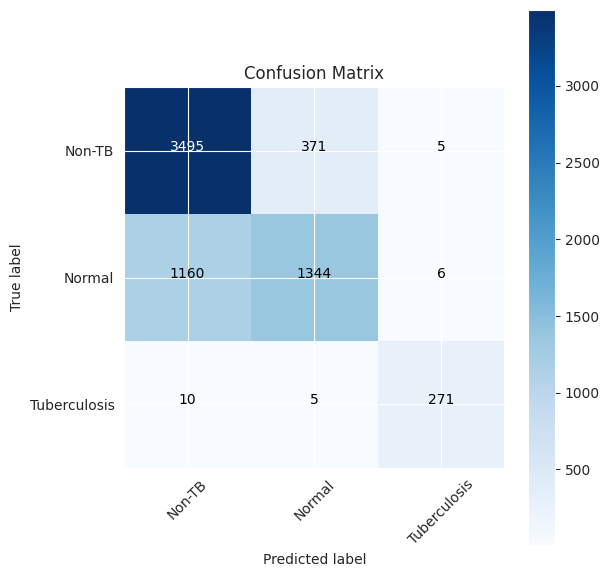

In [33]:
predictions = model.predict(val_generator, verbose=1)
preds = np.argmax(predictions, axis=1)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(val_generator.classes, preds)
plot_confusion_matrix(cm, CATEGORIES, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(val_generator.classes, preds, target_names=CATEGORIES))